            MSWEP_Cara  MSWEP_obi  obs_cara   obs_obi
MSWEP_Cara    1.000000   0.208016  0.886703 -0.019262
MSWEP_obi     0.208016   1.000000  0.278507  0.548317
obs_cara      0.886703   0.278507  1.000000  0.049890
obs_obi      -0.019262   0.548317  0.049890  1.000000


/Users/killaars/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:147: RuntimeWarning: divide by zero encountered in log


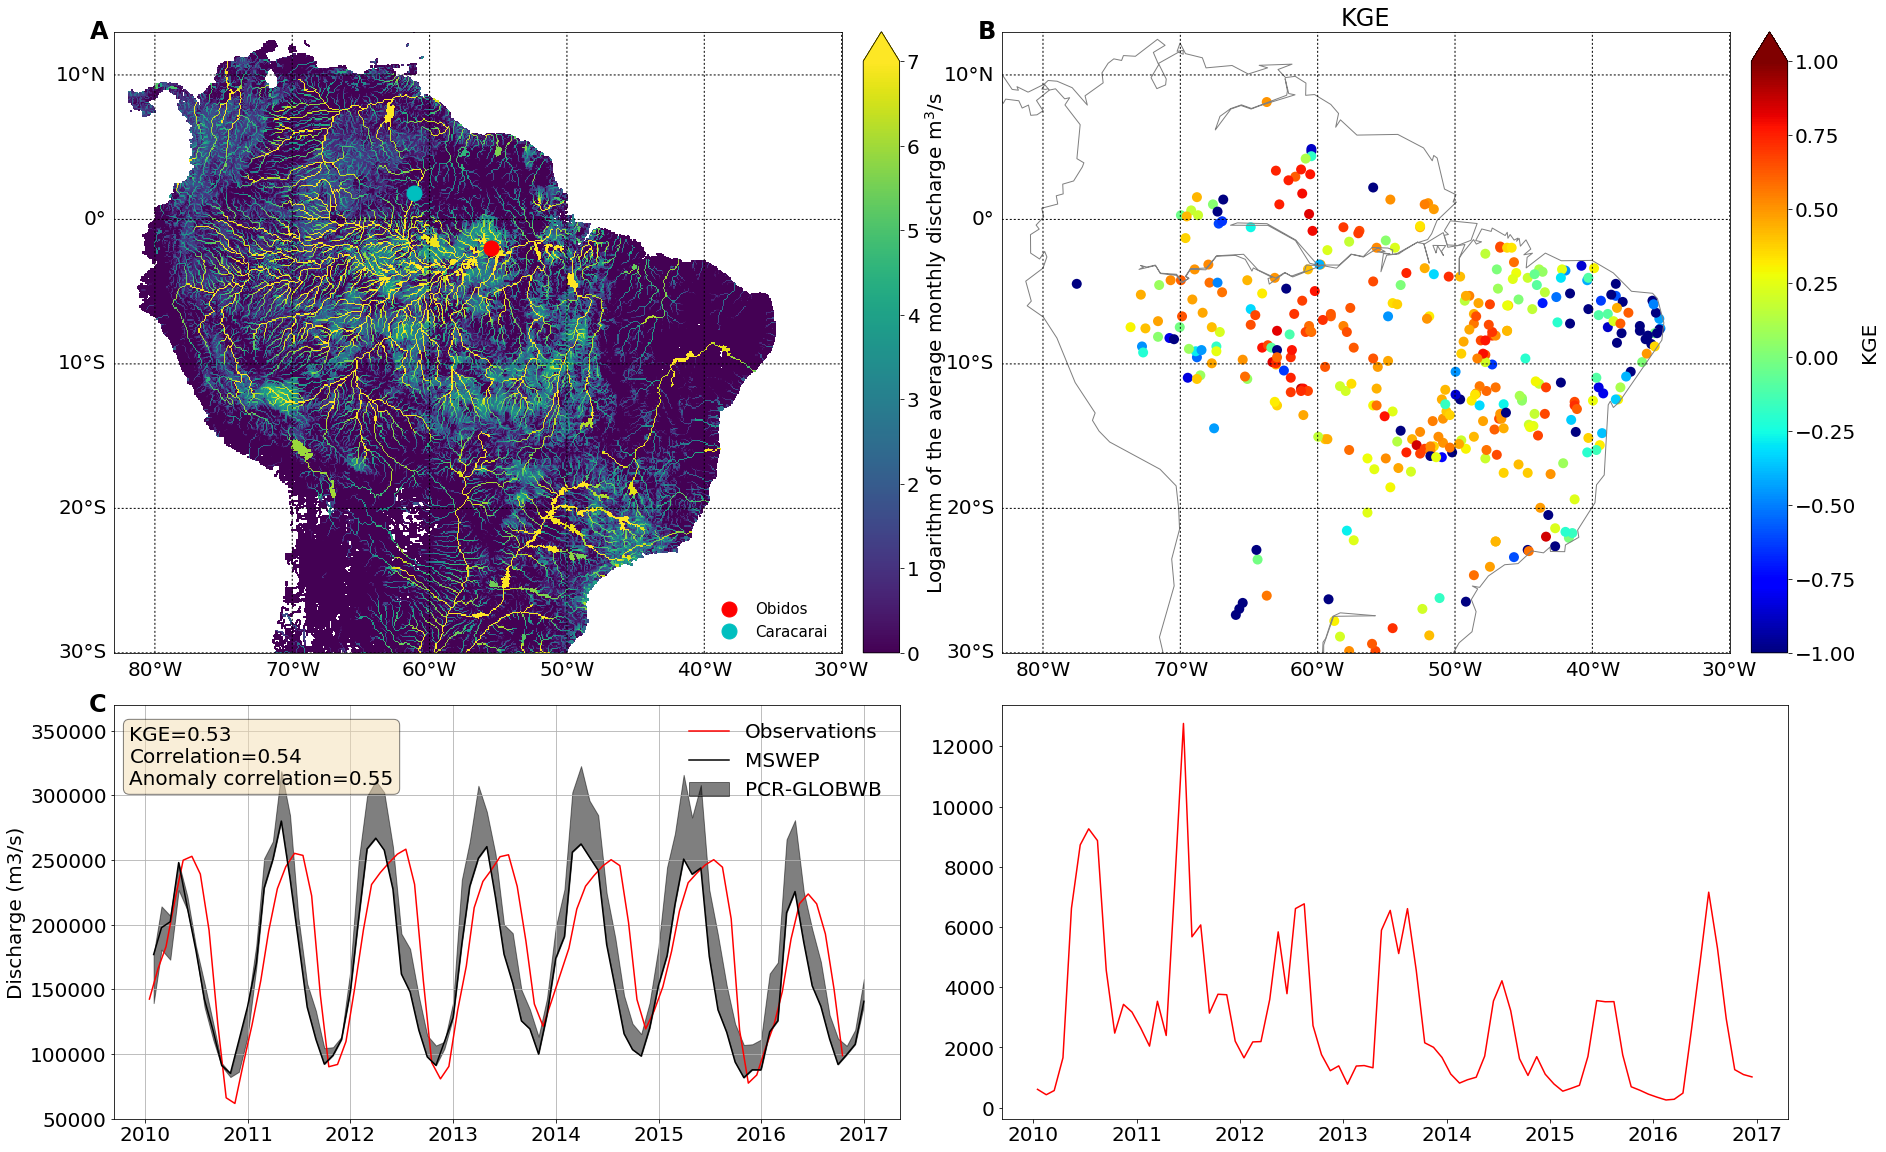

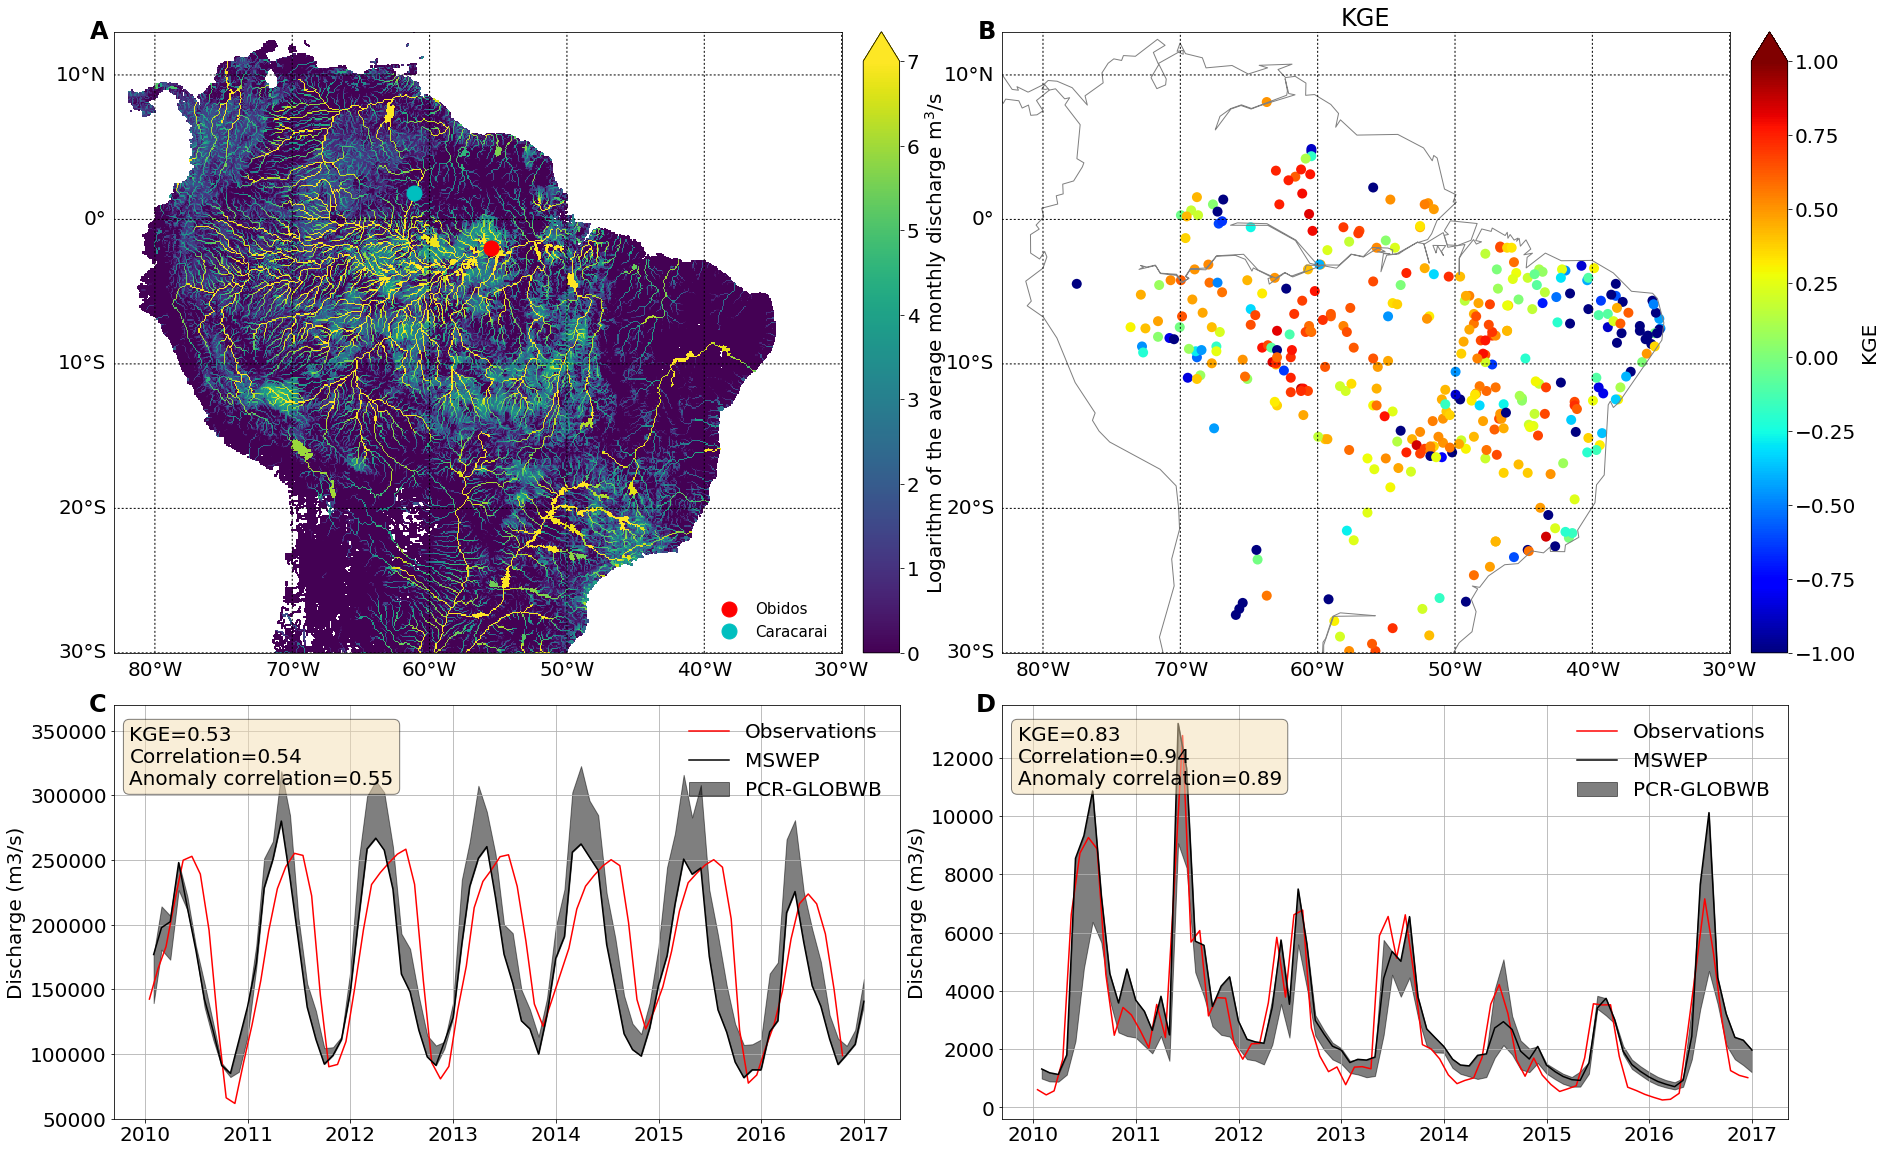

In [3]:
# Figure 1
import numpy as np
import pandas as pd
import os,sys
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

# Amazon data for monthly discharge - Panel A
path='/Users/killaars/PhD/Elnino/Discharge/'
ana_anomaly_fh = nc.Dataset(os.path.join(path,'MSWEP_newspinup_discharge_dailyTot_output.nc'),mode='r')

data_ama=ana_anomaly_fh.variables['discharge'][0,:,:]
lat_ama = ana_anomaly_fh.variables['latitude'][:]
lon_ama = ana_anomaly_fh.variables['longitude'][:]
lon_ama, lat_ama = np.meshgrid(lon_ama, lat_ama)

#KGE point plot - Panel B
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx],idx

# Locations Obidos and Congo
Obidos_lat=-1.94722
Obidos_lon=-55.51111
Caracarai_lat=1.82
Caracarai_lon=-61.12

# Read data from file
obidos = pd.read_csv('/Users/killaars/PhD/Elnino/Discharge/discharge_files_HYBAM/obidos_monthly.txt',sep=';')
caracarai = pd.read_csv('/Users/killaars/PhD/Elnino/Discharge/discharge_files_HYBAM/caracarai_monthly.txt',sep=';')
# Create index based on date column
obidos["new_date"]=pd.to_datetime(obidos["date"],format='%d/%m/%Y')
obidos=obidos.set_index('new_date')
caracarai["new_date"]=pd.to_datetime(caracarai["date"],format='%d/%m/%Y')
caracarai=caracarai.set_index('new_date')

# Merge the two datasets according to the index and drop the column 'date' from both. (axis=1 indicates that it is a column and not a row)
obsdata=pd.concat([obidos.drop(['date'],axis=1),caracarai.drop(['date'],axis=1)],axis=1)

# Read PCR lat/lon from MSWEP file
MSWEP_AMA=nc.Dataset('/Users/killaars/PhD/Elnino/Discharge/MSWEP_full_discharge_monthAvg_output.nc',mode='r')

lat_AMA = MSWEP_AMA.variables['latitude'][:]
lon_AMA = MSWEP_AMA.variables['longitude'][:]

# Match latitude to closest point in the PCR-GLOBWB output
lat_station_Obi,idy_Obi = find_nearest(lat_AMA,Obidos_lat)
lat_station_Cara,idy_Cara = find_nearest(lat_AMA,Caracarai_lat)

# Match longitude to closest point in the PCR-GLOBWB output
lon_station_Obi,idx_Obi = find_nearest(lon_AMA,Obidos_lon)
lon_station_Cara,idx_Cara = find_nearest(lon_AMA,Caracarai_lon)

# Read corresponding PCR data
TRMM_AMA=nc.Dataset('/Users/killaars/PhD/Elnino/Discharge/discharge_monthAvg_output_TRMM_2007_2016.nc',mode='r')
ERA5_AMA=nc.Dataset('/Users/killaars/PhD/Elnino/Discharge/discharge_monthAvg_output_ERA5_2010_2016.nc',mode='r')

MSWEP_obi=MSWEP_AMA.variables['discharge'][:,idy_Obi,idx_Obi]
TRMM_obi=TRMM_AMA.variables['discharge'][:,idy_Obi,idx_Obi]
ERA5_obi=ERA5_AMA.variables['discharge'][:,idy_Obi,idx_Obi]

MSWEP_Cara=MSWEP_AMA.variables['discharge'][:,idy_Cara,idx_Cara]
TRMM_Cara=TRMM_AMA.variables['discharge'][:,idy_Cara,idx_Cara]
ERA5_Cara=ERA5_AMA.variables['discharge'][:,idy_Cara,idx_Cara]

# Create timeseries from 2000-01-01 to 2016-12-31
timesMSWEP=pd.date_range('2000-01-01','2016-12-31',freq='M')
timesTRMM=pd.date_range('2007-01-01','2016-12-31',freq='M')
timesERA5=pd.date_range('2010-01-01','2016-12-31',freq='M')


# Load data in dataframe
MSWEP_series_obi=pd.Series(MSWEP_obi,index=timesMSWEP,name='MSWEP_obi')
TRMM_series_obi=pd.Series(TRMM_obi,index=timesTRMM,name='TRMM_obi')
ERA5_series_obi=pd.Series(ERA5_obi,index=timesERA5,name='ERA5_obi')

MSWEP_series_Cara=pd.Series(MSWEP_Cara,index=timesMSWEP,name='MSWEP_Cara')
TRMM_series_Cara=pd.Series(TRMM_Cara,index=timesTRMM,name='TRMM_Cara')
ERA5_series_Cara=pd.Series(ERA5_Cara,index=timesERA5,name='ERA5_Cara')

# Create min/max from the different PCR precip results
Plot_df=pd.concat([MSWEP_series_obi,TRMM_series_obi,ERA5_series_obi,MSWEP_series_Cara,TRMM_series_Cara,ERA5_series_Cara],axis=1)
Plot_df['min_obi']=Plot_df.loc[:,['MSWEP_obi','TRMM_obi','ERA5_obi']].min(axis=1)
Plot_df['max_obi']=Plot_df.loc[:,['MSWEP_obi','TRMM_obi','ERA5_obi']].max(axis=1)
Plot_df['min_Cara']=Plot_df.loc[:,['MSWEP_Cara','TRMM_Cara','ERA5_Cara']].min(axis=1)
Plot_df['max_Cara']=Plot_df.loc[:,['MSWEP_Cara','TRMM_Cara','ERA5_Cara']].max(axis=1)

def KGE_calc(sim,obs):
    dataframe = pd.DataFrame({'sim' : sim,
                              'obs' : obs})
    r = dataframe.corr().iloc[0,1]
    alfa=dataframe.std().loc['sim']/dataframe.std().loc['obs']
    beta = dataframe.mean().loc['sim']/dataframe.mean().loc['obs']
    ED = np.sqrt(((r-1)**2)+((alfa-1)**2)+((beta-1)**2))
    KGE = 1-ED
    return KGE,r

# Calculate KGE and r for obidos+caracarai
KGE_obi,r_obi=KGE_calc(Plot_df['MSWEP_obi'].values,obsdata['discharge obidos'].values)
KGE_Cara,r_Cara=KGE_calc(Plot_df['MSWEP_Cara'].values,obsdata['discharge caracarai'].values)

# Calculate anomaly correlation for obidos+caracarai
# Put all the relevant values in dataframe
ano_df=pd.DataFrame({'MSWEP_obi': Plot_df['MSWEP_obi'].values,
                     'MSWEP_Cara': Plot_df['MSWEP_Cara'].values,
                     'obs_obi': obsdata['discharge obidos'].values,
                     'obs_cara': obsdata['discharge caracarai'].values},index=timesMSWEP)
# Calculate monthly mean
month_mean=ano_df.groupby([ano_df.index.month]).mean()
# Create empty dataframe where anomalies will be stored
all_anomalies=pd.DataFrame(index=timesMSWEP)
# Calculate monthly anomaly for each column and store results in empty dataframe from above
for column in ano_df.columns:
    for index in all_anomalies.index:
        # Select the relevant monthly mean
        month=pd.to_datetime(index).month
        # Actual calculation
        all_anomalies.loc[index,column]=ano_df.loc[index,column]-month_mean.loc[month,column]
# Calculate anomaly correlation for all columns
anomaly_correlation=all_anomalies.corr()
print(anomaly_correlation)
# Select relevant values for both basins
ano_r_obi=anomaly_correlation.iloc[1,3]
ano_r_Cara=anomaly_correlation.iloc[0,2]

# Only keep data from 2010 onwards
Plot_df=Plot_df['2010':'2016']
obsdata=obsdata['2010':'2016']

# -- Set font settings

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 20})

# -- Create figure
fig = plt.figure(figsize=[30,20])
gs = GridSpec(2,2,width_ratios=[1,1],height_ratios=[1.5,1])
gs.update(wspace=0.13,hspace=0.1)
clim=0,7

# Ax1 monthly discharge amazon basin
ax1 = fig.add_subplot(gs[0,0])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-30,fix_aspect=False)
m.pcolormesh(lon_ama, lat_ama, np.log(data_ama[:,:]),
             latlon=True, cmap='viridis')
parallels = np.linspace(-90.,90.,19)
m.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.linspace(0.,360.,37)
m.drawmeridians(meridians,labels=[False,False,False,True])
cbar1 = m.colorbar(location='right',pad=0.3,extend='max',label=r'Logarithm of the average monthly discharge $m^3/s$')
x,y = m(Obidos_lon, Obidos_lat)    
m.plot(x,y, 'ro', markersize=15,label='Obidos')
x,y = m(Caracarai_lon, Caracarai_lat)                            
m.plot(x,y, 'co', markersize=15,label='Caracarai')
ax1.text(-0.02,1.0,'A',transform=ax1.transAxes,va='center',ha='center',weight='bold',size='large')
plt.legend(frameon=False,fontsize=15)
#plt.tick_params(labelsize=15) 
plt.clim(clim)

# Ax2 = KGE point plot
ax2 = fig.add_subplot(gs[0,1])
data_kgeplot = pd.read_csv('/Users/killaars/PhD/Elnino/Discharge/summary_MSWEP_all_hybam.txt',sep=";",index_col='id_from_grdc')
data_kgeplot=data_kgeplot[data_kgeplot['num_of_month_pairs']>12]
data_kgeplot=data_kgeplot[data_kgeplot['model_longitude_in_arc_degree']<-35]
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-30,fix_aspect=False)
m.drawcoastlines(color='.5')
parallels = np.linspace(-90.,90.,19)
m.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.linspace(0.,360.,37)
m.drawmeridians(meridians,labels=[False,False,False,True])
x,y = m(data_kgeplot["model_longitude_in_arc_degree"].values, data_kgeplot["model_latitude_in_arc_degree"].values)
sc = plt.scatter(x,y, c=data_kgeplot['kge_2012'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=100, edgecolors='none')
cbar2 = m.colorbar(location='right',pad=0.3,extend='max',label='KGE')
# cbar = plt.colorbar(sc, shrink = .5)
# cbar.set_label("KGE")
plt.title('KGE')
#plt.tick_params(labelsize=15) 
ax2.text(-0.02,1.0,'B',transform=ax2.transAxes,va='center',ha='center',weight='bold',size='large')

# Ax 3 and 4: Discharge at Obidos and Caracarai
ax3 = fig.add_subplot(gs[1,0])
#ax3.set_title("Discharge Amazon at Obidos",fontsize='15')
ax3.plot(obsdata.index, obsdata['discharge obidos'], 'r',label='Observations')
ax3.plot(Plot_df.index, Plot_df['MSWEP_obi'], 'k',label='MSWEP')
ax3.fill_between(Plot_df.index, Plot_df['min_obi'], 
                 Plot_df['max_obi'], color='k', alpha=0.5,label='PCR-GLOBWB')
plt.ylabel('Discharge (m3/s)')
plt.ylim(50000,370000)
plt.legend(frameon=False)
# Textbox with skill scores
textstr = 'KGE=%.2f\nCorrelation=%.2f\nAnomaly correlation=%.2f'%(KGE_obi, r_obi, ano_r_obi)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax3.text(0.02, 0.95, textstr, transform=ax3.transAxes,
        verticalalignment='top', bbox=props)
plt.grid(True)
ax3.text(-0.02,1.0,'C',transform=ax3.transAxes,va='center',ha='center',weight='bold',size='large')

ax4 = fig.add_subplot(gs[1,1])
#ax4.set_title("Discharge Amazon at Caracarai",fontsize='15')
ax4.plot(obsdata.index, obsdata['discharge caracarai'], 'r',label='Observations')
ax4.plot(Plot_df.index, Plot_df['MSWEP_Cara'], 'k',label='MSWEP')
ax4.fill_between(Plot_df.index, Plot_df['min_Cara'], 
                 Plot_df['max_Cara'], color='k', alpha=0.5,label='PCR-GLOBWB')
plt.ylabel('Discharge (m3/s)')
plt.legend(frameon=False)

# Textbox with skill scores
textstr = 'KGE=%.2f\nCorrelation=%.2f\nAnomaly correlation=%.2f'%(KGE_Cara, r_Cara, ano_r_Cara)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax4.text(0.02, 0.95, textstr, transform=ax4.transAxes,
        verticalalignment='top', bbox=props)
plt.grid(True)
ax4.text(-0.02,1.0,'D',transform=ax4.transAxes,va='center',ha='center',weight='bold',size='large')

plt.savefig("/Users/killaars/PhD/Elnino/Figures_paper/Figure_1.pdf", bbox_inches='tight', dpi=300)
plt.show()

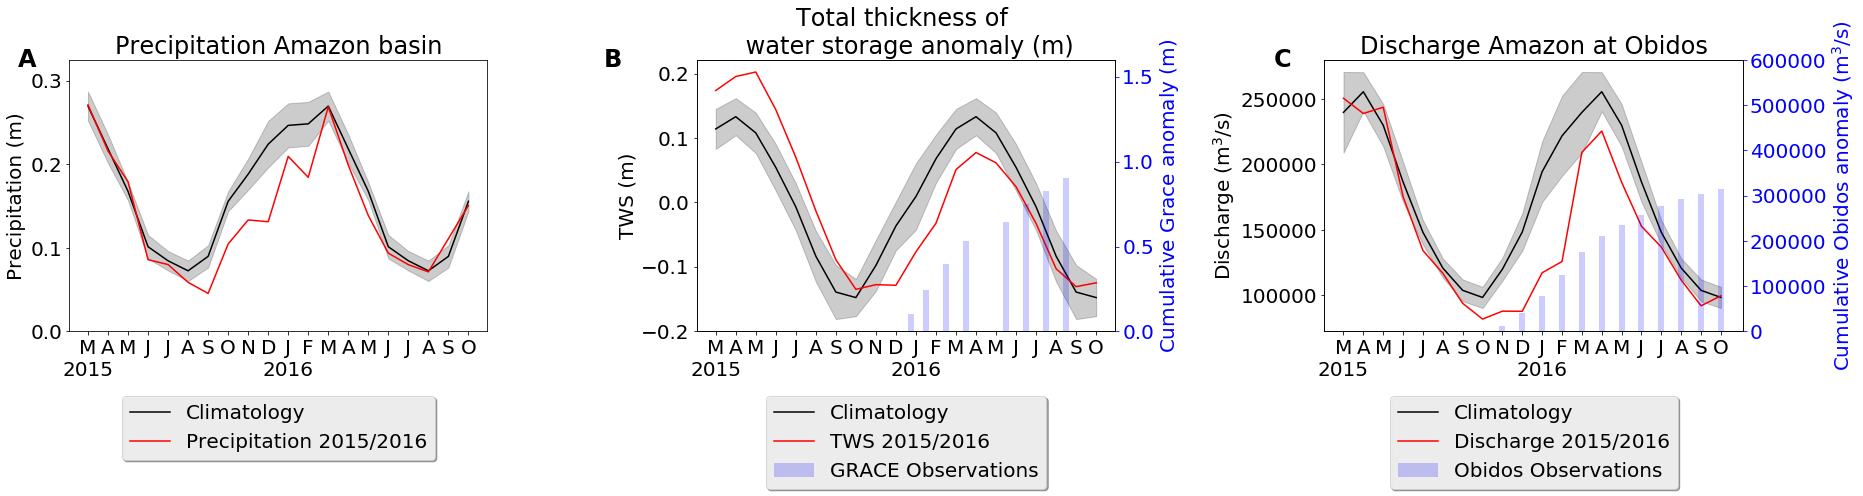

In [16]:
# Figure 2 
import datetime
import numpy as np
import pandas as pd
import os,sys
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from datetime import timedelta

grace = pd.read_csv('/Users/killaars/PhD/Elnino/grace/grace_anomaly.txt',sep='\t',skiprows=3)
startdate=datetime.datetime.strptime('2002 01 01  00:00:00', '%Y %m %d %H:%M:%S')


for index in grace.index:
    grace.loc[index,'date']=startdate+ timedelta(days=grace.loc[index,'time (days since 2002-1-1 00:00:00)'])

# Newdate for pandas slicing
grace["new_date"]=pd.to_datetime(grace["date"],format='%d/%m/%Y')
grace=grace.set_index('new_date')

# Read Discharge data from file
obidos = pd.read_csv('/Users/killaars/PhD/Elnino/Discharge/discharge_files_HYBAM/obidos_monthly.txt',sep=';')
# Create index based on date column
obidos["new_date"]=pd.to_datetime(obidos["date"],format='%d/%m/%Y')
obidos=obidos.set_index('new_date')
# Save it to obsdata
obsdata=obidos


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx],idx

# Location Obidos
Obidos_lat=-1.94722
Obidos_lon=-55.51111

path='/Users/killaars/PhD/Elnino/Discharge/'
MSWEP_ama_fh=nc.Dataset(os.path.join(path,'MSWEP_full_discharge_monthAvg_output.nc'),mode='r')
path='/Users/killaars/PhD/Elnino/data_figure2/'
discharge_ama_fh=nc.Dataset(os.path.join(path,'discharge_monthAvg_masked_fldmean.nc'),mode='r')
precip_ama_fh=nc.Dataset(os.path.join(path,'precipitation_monthTot_masked_fldmean.nc'),mode='r')
TWS_ama_fh=nc.Dataset(os.path.join(path,'totalWaterStorageThickness_monthAvg_masked_fldmean.nc'),mode='r')

# First find PCR_location, so the whole dataset does not have to be loaded
lat_AMA = MSWEP_ama_fh.variables['latitude'][:]
lon_AMA = MSWEP_ama_fh.variables['longitude'][:]

# Match latitude to closest point in the PCR-GLOBWB output
lat_station_Obi,idy_Obi = find_nearest(lat_AMA,Obidos_lat)

# Match longitude to closest point in the PCR-GLOBWB output
lon_station_Obi,idx_Obi = find_nearest(lon_AMA,Obidos_lon)

# Load data from that point
data_Obi=MSWEP_ama_fh.variables['discharge'][:,idy_Obi,idx_Obi]

# Create timeseries to be used later
times=pd.date_range('1/1/2000', '31/12/2016', freq='M')
times_ENSO=pd.date_range('1/1/2015', '31/12/2016', freq='M')

# Initialise TWS series
TWS=pd.Series(TWS_ama_fh.variables['total_thickness_of_water_storage'][:,0,0],index=pd.date_range('1/1/2010', '31/12/2016', freq='M'))

# Put data in dataframe - so you can groupby month
figure2_df=pd.DataFrame({'discharge_obidos': data_Obi,
                         'discharge_whole_basin' : discharge_ama_fh.variables['discharge'][:,0,0],
                         'precipitation' : precip_ama_fh.variables['precipitation'][:,0,0]*1000},index=times)

figure2_df['TWS']=TWS

# Groupby month for the period 2000-2014 (includes 2014)
climatology=figure2_df['2000':'2014'].groupby(figure2_df['2000':'2014'].index.month).mean()
climatology_std=figure2_df['2000':'2014'].groupby(figure2_df['2000':'2014'].index.month).std()

# Put the climatology twice in an array, because plot is 2 years long
climatology_obi = np.append(climatology['discharge_obidos'].values,climatology['discharge_obidos'].values)
climatology_obi_std = np.append(climatology_std['discharge_obidos'].values,climatology_std['discharge_obidos'].values)
climatology_ama = np.append(climatology['discharge_whole_basin'].values,climatology['discharge_whole_basin'].values)
climatology_ama_std = np.append(climatology_std['discharge_whole_basin'].values,climatology_std['discharge_whole_basin'].values)
climatology_precip = np.append(climatology['precipitation'].values,climatology['precipitation'].values)
climatology_precip_std = np.append(climatology_std['precipitation'].values,climatology_std['precipitation'].values)
climatology_TWS = np.append(climatology['TWS'].values,climatology['TWS'].values)
climatology_TWS_std = np.append(climatology_std['TWS'].values,climatology_std['TWS'].values)

# Put 2016 after 2015 in one array
ENSO_obi=np.append(figure2_df['2015']['discharge_obidos'].values,figure2_df['2016']['discharge_obidos'].values)
ENSO_ama=np.append(figure2_df['2015']['discharge_whole_basin'].values,figure2_df['2016']['discharge_whole_basin'].values)
ENSO_precip=np.append(figure2_df['2015']['precipitation'].values,figure2_df['2016']['precipitation'].values)
ENSO_TWS=np.append(figure2_df['2015']['TWS'].values,figure2_df['2016']['TWS'].values)

# Put values in dataframe that will be plotted
plot_df=pd.DataFrame({'ENSO Obidos': ENSO_obi,
                      'Climatology Obidos': climatology_obi,
                      'Climatology Obidos STD': climatology_obi_std,
                      'ENSO Precipitation': ENSO_precip,
                      'Climatology Precipitation': climatology_precip,
                      'Climatology Precipitation STD': climatology_precip_std,
                      'ENSO TWS': ENSO_TWS,
                      'Climatology TWS': climatology_TWS,
                      'Climatology TWS STD': climatology_TWS_std,
                      'ENSO Amazon': ENSO_ama,
                      'Climatology Amazon': climatology_ama,
                      'Climatology Amazon STD': climatology_ama_std}, index=times_ENSO)

# Monthly anomaly obidos
month_mean=obsdata.groupby([obsdata.index.month]).mean()
for index in obsdata.index.values:
    #print(index)
    month=pd.to_datetime(index).month
    obsdata.loc[index,'observation_anomaly']=obsdata.loc[index,'discharge obidos']-month_mean.loc[int(month),'discharge obidos']

# Cut off dataframe from 03-3015 to 06-2016
#print(plot_df['ENSO Obidos']/plot_df['Climatology Obidos'])
plot_df=plot_df['2015-3':'2016-10']
obsdata=obsdata['2015-10':'2016-10']
grace=grace['2015-10':'2016-10']
grace =grace/100 # to meter

# Cumulative values for Grace and Obidos observations
grace_cumsum=np.cumsum(grace['lwe_thickness (cm)'])
obidos_cumsum=np.cumsum(obsdata['observation_anomaly'])

# Zero in september and invert axis
grace_cumsum=np.append(0,grace_cumsum)*-1
obidos_cumsum=np.append(0,obidos_cumsum)*-1

# -- Set font settings
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 20})

# Plot dataframe
fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(131)
ax1.set_title("Precipitation Amazon basin")
plt.plot(np.arange(20), plot_df['Climatology Precipitation']/1000, 'k',label='Climatology')
plt.plot(np.arange(20), plot_df['ENSO Precipitation']/1000, 'r',label='Precipitation 2015/2016')
plt.fill_between(np.arange(20), plot_df['Climatology Precipitation']/1000-plot_df['Climatology Precipitation STD']/1000, 
                 plot_df['Climatology Precipitation']/1000+plot_df['Climatology Precipitation STD']/1000, color='k', alpha=0.2)
plt.ylabel('Precipitation (m)')
plt.ylim(0,0.325)
plt.xticks(np.arange(20),['M\n2015','A','M','J','J','A','S','O','N','D','J\n2016','F','M','A','M','J','J','A','S','O'])

# plt.axvspan(datetime.datetime.strptime("15-06-2015", '%d-%m-%Y'), 
#             datetime.datetime.strptime("15-09-2015", '%d-%m-%Y'), 
#             color='grey',alpha=0.2)
ax1.text(-0.1,1.0,'A',transform=ax1.transAxes,va='center',ha='center',weight='bold',size='large')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True)

# Or total water storage
ax2 = fig.add_subplot(132)
ax2.set_title("Total thickness of \n water storage anomaly (m)")
l1=plt.plot(np.arange(20), plot_df['Climatology TWS']-plot_df['Climatology TWS'].mean(), 'k',label='Climatology')
l2=plt.plot(np.arange(20), plot_df['ENSO TWS']-plot_df['ENSO TWS'].mean(), 'r',label='TWS 2015/2016')
l3=plt.fill_between(np.arange(20), plot_df['Climatology TWS']-plot_df['Climatology TWS'].mean()-plot_df['Climatology TWS STD'], 
                 plot_df['Climatology TWS']-plot_df['Climatology TWS'].mean()+plot_df['Climatology TWS STD'], color='k', alpha=0.2)
plt.ylabel('TWS (m)')
plt.xticks(np.arange(20),['M\n2015','A','M','J','J','A','S','O','N','D','J\n2016','F','M','A','M','J','J','A','S','O'])

ax2.text(-0.2,1.0,'B',transform=ax2.transAxes,va='center',ha='center',weight='bold',size='large')

ax4 = ax2.twinx()
l4=plt.bar([6.5,9.75,10.5,11.5,12.5,14.5,15.5,16.5,17.5], grace_cumsum, width=0.3,color='b',label='GRACE Observations',alpha=0.2)
plt.ylabel('Cumulative Grace anomaly ($m$)', color='b')
plt.ylim(0,1.6)
ax4.tick_params(colors='b')

handles,labels = [],[]
for ax in ax2,ax4:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
ax2.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True)

ax3 = fig.add_subplot(133)
ax3.set_title("Discharge Amazon at Obidos")
plt.plot(np.arange(20), plot_df['Climatology Obidos'], 'k',label='Climatology')
plt.plot(np.arange(20), plot_df['ENSO Obidos'], 'r',label='Discharge 2015/2016')
#plt.plot(np.arange(20), obsdata['discharge obidos'], 'b',label='Observations')
plt.fill_between(np.arange(20), plot_df['Climatology Obidos']-plot_df['Climatology Obidos STD'], 
                 plot_df['Climatology Obidos']+plot_df['Climatology Obidos STD'], color='k', alpha=0.2)
plt.ylabel('Discharge ($m^3/s$)')
plt.xticks(np.arange(20),['M\n2015','A','M','J','J','A','S','O','N','D','J\n2016','F','M','A','M','J','J','A','S','O'])

ax5 = ax3.twinx()
#l4=plt.plot(6+np.arange(14), obidos_cumsum, 'b',label='Obidos Observations',marker='o')
l4=plt.bar(6+np.arange(14), obidos_cumsum, width=0.3,color='b',label='Obidos Observations',alpha=0.2)
plt.ylim(0,600000)
plt.ylabel('Cumulative Obidos anomaly ($m^3/s$)', color='b')
ax5.tick_params(colors='b')

handles,labels = [],[]
for ax in ax3,ax5:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
ax3.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True)
ax3.text(-0.1,1.0,'C',transform=ax3.transAxes,va='center',ha='center',weight='bold',size='large')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=None)
plt.savefig("/Users/killaars/PhD/Elnino/Figures_paper/Figure_2.pdf", bbox_inches='tight', dpi=300)
plt.show()

(6, 828, 576)


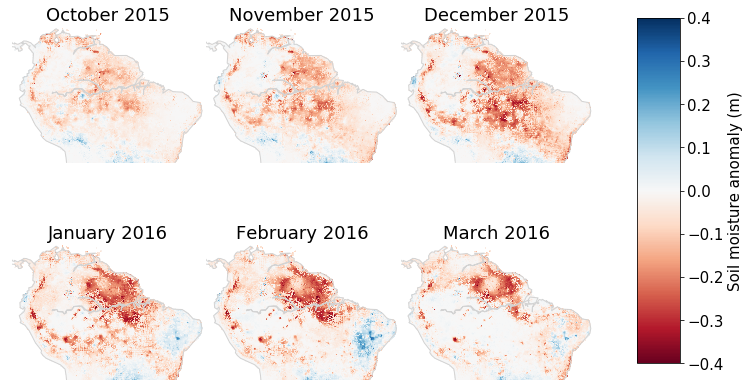

In [69]:
# Figure 3
# Data comes from file /scratch/shared/lars/PCRGLOBWB/MSWEP_full_series/anomaly/anomaly.nc on cartesius
path='/Users/killaars/PhD/Elnino/anomaly_plot'
anomaly_fh = nc.Dataset(os.path.join(path,'storSoilTotal_monthAvg_anomaly_figure.nc'),mode='r')
# anomaly_fh = nc.Dataset(os.path.join(path,'referencePotET_05min_monmean_anomaly_SA_ensoperiod.nc'),mode='r')

data=anomaly_fh.variables['lower_soil_storage'][:]
lat = anomaly_fh.variables['latitude'][:]
lon = anomaly_fh.variables['longitude'][:]
# data=anomaly_fh.variables['referencePotET'][:]
# lat = anomaly_fh.variables['lat'][:]
# lon = anomaly_fh.variables['lon'][:]
lon, lat = np.meshgrid(lon, lat)
print(np.shape(data))

# -- Set font settings
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 15})

# Set clim once for all 6 plots. 
clim=-.4, 0.4
cmap='RdBu'
# -- Create figure
fig = plt.figure(figsize=[12,8])
#fig.suptitle('Soil moisture storage anomaly (m) for the ENSO event of 2015/2016',fontsize='20')#, y=0.65) #y to fix the y-position, otherwise title would float.
gs = GridSpec(2,3,width_ratios=[1,1,1],height_ratios=[1,1])
gs.update(wspace=0,hspace=0.0)

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("October 2015")
m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
            llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,\
            rsphere=6371200.,resolution='c',area_thresh=10000)
m.pcolormesh(lon, lat, data[0,:,:],
             latlon=True, cmap=cmap)
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("November 2015")
m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
            llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,\
            rsphere=6371200.,resolution='c',area_thresh=10000)
m.pcolormesh(lon, lat, data[1,:,:],
             latlon=True, cmap=cmap)
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax3 = fig.add_subplot(gs[0,2])
ax3.set_title("December 2015")
m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
            llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,\
            rsphere=6371200.,resolution='c',area_thresh=10000)
m.pcolormesh(lon, lat, data[2,:,:],
             latlon=True, cmap=cmap)
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax4 = fig.add_subplot(gs[1,0])
ax4.set_title("January 2016")
m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
            llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,\
            rsphere=6371200.,resolution='c',area_thresh=10000)
m.pcolormesh(lon, lat, data[3,:,:] ,
             latlon=True, cmap=cmap)
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax5 = fig.add_subplot(gs[1,1])
ax5.set_title("February 2016")
m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
            llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,\
            rsphere=6371200.,resolution='c',area_thresh=10000)
m.pcolormesh(lon, lat, data[4,:,:],
             latlon=True, cmap=cmap)
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax6 = fig.add_subplot(gs[1,2])
ax6.set_title("March 2016")
m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
            llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,\
            rsphere=6371200.,resolution='c',area_thresh=10000)
m.pcolormesh(lon, lat, data[5,:,:],
             latlon=True, cmap=cmap)
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

im = plt.gca().get_children()[0]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.225, 0.05, 0.6])
fig.colorbar(im,cax=cbar_ax,label='Soil moisture anomaly (m)')


#plt.savefig("/Users/killaars/PhD/Elnino/Figures_paper/Figure_3.png", bbox_inches='tight', dpi=300)
plt.show()

[-1.20567596 -1.80286511 -0.82459535 -2.92119227 -4.13071244 -3.72629503
 -2.69024379 -0.73896301 -4.93812958 -4.25020268 -1.77321204  1.04075698
 -0.10303483  0.93841806  0.46852626]
[  0.6258642   -0.28219877  -2.3491599   -7.57066315 -13.87326636
 -15.14709843 -19.12275172 -18.47461069 -12.39707664  -9.68862541
  -1.82269657   1.99954369   0.40515011  -1.57334446  -4.15606793]
[  1.03927518   1.76933389   1.54150105  -1.64010306 -11.90301121
 -15.26440521 -17.40774022 -15.70490877  -1.15220292  -6.14995899
  -3.52481569  -1.22292933  -3.9017899   -5.79951468  -7.00245672]


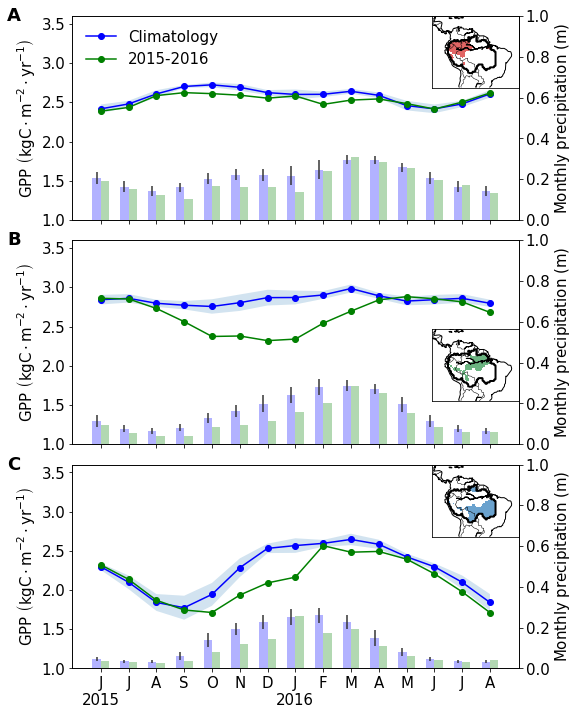

In [70]:
import pickle
import matplotlib.colors as colors

# -- Load Amazon mask
g = nc.Dataset('/Users/killaars/PhD/Elnino/Figures_paper/amazon_mask30.nc')
amazon = g.variables['regionmask'][:] # -
g.close()

# -- Koppen climate regions
q = nc.Dataset('/Users/killaars/PhD/Elnino/Figures_paper/koppen_regions_30.nc')
koppen = q.variables['regionmask'][:] # -
q.close()

koppen=np.around(koppen)

# ==== CONSTRUCT MASK

# -- Reverse latitudes
amazon = amazon[::-1,:]
koppen = koppen[::-1,:]

# -- Select Amazon regions
rainforest_amazon = amazon*(koppen==1)
monsoon_amazon = amazon*(koppen==2)
savanna_amazon = amazon*(koppen==3)

# -- Determine color norm
region_norm = colors.Normalize(vmin=0.5,vmax=1.2)
pcr_r1 = pickle.load(open('/Users/killaars/PhD/Elnino/pickle/pcr_r1.p', 'rb'))
pcr_r2 = pickle.load(open('/Users/killaars/PhD/Elnino/pickle/pcr_r2.p', 'rb'))
pcr_r3 = pickle.load(open('/Users/killaars/PhD/Elnino/pickle/pcr_r3.p', 'rb'))

# Multiply by 0.378432 to convert from umol m-2 s-1 naar KgC m-2 yr-1
conversion = 1
conversion = 0.378432
r1_clim=pcr_r1[0]*conversion
r1_std=pcr_r1[1]*conversion
r1_enso=pcr_r1[2]*conversion

r2_clim=pcr_r2[0]*conversion
r2_std=pcr_r2[1]*conversion
r2_enso=pcr_r2[2]*conversion

r3_clim=pcr_r3[0]*conversion
r3_std=pcr_r3[1]*conversion
r3_enso=pcr_r3[2]*conversion

# percentage decrease
print(100*(r1_enso-r1_clim)/r1_clim)
print(100*(r2_enso-r2_clim)/r2_clim)
print(100*(r3_enso-r3_clim)/r3_clim)

# Load in precip data and select the correct months
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg1_runsum30_enso_monmean.nc') as d:
        r1_p_enso      = d['precipitation'][5:20,0,0]
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg2_runsum30_enso_monmean.nc') as d:
        r2_p_enso      = d['precipitation'][5:20,0,0]
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg3_runsum30_enso_monmean.nc') as d:
        r3_p_enso      = d['precipitation'][5:20,0,0]
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg1_runsum30_ymonmean.nc') as d:
        r1_p_clim      = d['precipitation'][:]
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg2_runsum30_ymonmean.nc') as d:
        r2_p_clim      = d['precipitation'][:]
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg3_runsum30_ymonmean.nc') as d:
        r3_p_clim      = d['precipitation'][:]
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg1_runsum30_ymonstd.nc') as d:
        r1_p_clim_std      = d['precipitation'][:]
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg2_runsum30_ymonstd.nc') as d:
        r2_p_clim_std     = d['precipitation'][:]
with nc.Dataset('/Users/killaars/PhD/Elnino/precip/fldmean_reg3_runsum30_ymonstd.nc') as d:
        r3_p_clim_std      = d['precipitation'][:]

# Climatology is only one year, append another to get two years and select the correct months
r1_p_clim = np.append(r1_p_clim,r1_p_clim)
r1_p_clim = r1_p_clim[5:20]
r2_p_clim = np.append(r2_p_clim,r2_p_clim)
r2_p_clim = r2_p_clim[5:20]
r3_p_clim = np.append(r3_p_clim,r3_p_clim)
r3_p_clim = r3_p_clim[5:20]
r1_p_clim_std = np.append(r1_p_clim_std,r1_p_clim_std)
r1_p_clim_std = r1_p_clim_std[5:20]
r2_p_clim_std = np.append(r2_p_clim_std,r2_p_clim_std)
r2_p_clim_std = r2_p_clim_std[5:20]
r3_p_clim_std = np.append(r3_p_clim_std,r3_p_clim_std)
r3_p_clim_std = r3_p_clim_std[5:20]

# -- Set font settings
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 15})

# -- Create figure
fig = plt.figure(figsize=[8,12])
gs = GridSpec(3,1,height_ratios=[1,1,1])
gs.update(hspace=0.1)
ylim=(1,3.6)
width=0.3
precipalpha = 0.3

# -- Plot SIF for rainforest
ax1 = fig.add_subplot(gs[0,0])
plt.plot(np.arange(15),r1_clim,'bo-',label='Climatology')
plt.plot(np.arange(15),r1_enso,'go-',label='2015-2016')
plt.fill_between(np.arange(15),r1_clim-r1_std,
                 r1_clim+r1_std,alpha=0.2)
# plt.axvspan(3.2667,3.8,color='grey',alpha=0.2) # Grey band for dry season
plt.xlim(0,14)
plt.ylim(ylim)
plt.xticks(np.arange(15),[])
#plt.legend(loc=(0.1,0.05),frameon=False)
plt.legend(loc='upper left',frameon=False)
ax1.text(-0.13,1.0,'A',transform=ax1.transAxes,va='center',ha='center',weight='bold',size='large')
ax1.set_ylabel(r'GPP $\left(kgC\cdot m^{-2}\cdot yr^{-1}\right)$',fontsize=15)

# -- Plot inset for rainforest location
plt.axes([0.75,0.764,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(rainforest_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Reds',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

# Plot precip bars
ax4 = ax1.twinx()
l4=plt.bar(np.arange(15)-width/2, r1_p_clim, yerr=r1_p_clim_std, width=width,color='b',alpha=precipalpha,ecolor='0.2')
l5=plt.bar(np.arange(15)+width/2, r1_p_enso, width=width,color='g',alpha=precipalpha)
plt.ylabel('Monthly precipitation ($m$)', color='black',fontsize=15)
plt.ylim(0,1)
ax4.tick_params(colors='black')

# -- Plot SIF for monsoon
ax2 = fig.add_subplot(gs[1,0])
plt.plot(np.arange(15),r2_clim,'bo-',label='Climatology')
plt.plot(np.arange(15),r2_enso,'go-',label='2015-2016')
plt.fill_between(np.arange(15),r2_clim-r2_std,
                 r2_clim+r2_std,alpha=0.2)
# plt.axvspan(0.5,4,color='grey',alpha=0.3) # Vertical shading
# plt.axvspan(12.5,14,color='grey',alpha=0.3)
# plt.axvspan(0.3667,4.71,color='grey',alpha=0.2)
# plt.axvspan(12.2667,14,color='grey',alpha=0.2)
plt.xlim(0,14)
plt.ylim(ylim)
plt.xticks(np.arange(15),[])
ax2.text(-0.13,1.0,'B',transform=ax2.transAxes,va='center',ha='center',weight='bold',size='large')
ax2.set_ylabel(r'GPP $\left(kgC\cdot m^{-2}\cdot yr^{-1}\right)$',fontsize=15)

# -- Plot inset for monsoon location
plt.axes([0.75,0.401,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(monsoon_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Greens',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

# Plot precip bars
ax5 = ax2.twinx()
l4=plt.bar(np.arange(15)-width/2, r2_p_clim, yerr=r2_p_clim_std, width=width,color='b',alpha=precipalpha,ecolor='0.2')
l5=plt.bar(np.arange(15)+width/2, r2_p_enso, width=width,color='g',alpha=precipalpha)
plt.ylabel('Monthly precipitation ($m$)', color='black',fontsize=15)
plt.ylim(0,1)
ax4.tick_params(colors='black')

# -- Plot SIF for savanna
ax3 = fig.add_subplot(gs[2,0])
plt.plot(np.arange(15),r3_clim,'bo-',label='Climatology')
plt.plot(np.arange(15),r3_enso,'go-',label='2015-2016')
plt.fill_between(np.arange(15),r3_clim-r3_std,
                 r3_clim+r3_std,alpha=0.2)
# plt.axvspan(0,4,color='grey',alpha=0.3) # Vertical shading
# plt.axvspan(11,14,color='grey',alpha=0.3)
# plt.axvspan(0,4.65,color='grey',alpha=0.2)
# plt.axvspan(10.9,14,color='grey',alpha=0.2)
plt.xlim(0,14)
plt.ylim(ylim)
plt.xticks(np.arange(15),['J\n2015','J','A','S','O','N','D','J\n2016','F','M','A','M','J','J','A'])
ax3.text(-0.13,1.0,'C',transform=ax3.transAxes,va='center',ha='center',weight='bold',size='large')
ax3.set_ylabel(r'GPP $\left(kgC\cdot m^{-2}\cdot yr^{-1}\right)$',fontsize=15)

# -- Plot inset for savanna location
plt.axes([0.75,0.244,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(savanna_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Blues',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

# Plot precip bars
ax6 = ax3.twinx()
l4=plt.bar(np.arange(15)-width/2, r3_p_clim, yerr=r3_p_clim_std, width=width,color='b',alpha=precipalpha,ecolor='0.2')
l5=plt.bar(np.arange(15)+width/2, r3_p_enso, width=width,color='g',alpha=precipalpha)
plt.ylabel('Monthly precipitation ($m$)', color='black',fontsize=15)
plt.ylim(0,1)
ax4.tick_params(colors='black')

#plt.savefig("/Users/killaars/PhD/Elnino/Figures_paper/Figure_4.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [60]:
my_data = np.genfromtxt('/Users/killaars/PhD/Elnino/pickle/pcr_r1.csv', delimiter=',')
print(my_data)

[[ 3.23655282  3.33037083  3.50004918  3.62310463  3.64697819  3.59945765
   3.52466692  3.49647013  3.512323    3.54782662  3.4821986   3.27472243
   3.23655282  3.33037083  3.50004918]
 [ 0.07315188  0.03018945  0.04006883  0.04952911  0.05684489  0.05187106
   0.03992488  0.05638897  0.05017122  0.06698499  0.05823016  0.09473206
   0.07315188  0.03018945  0.04006883]
 [ 3.26052291  3.33483273  3.57007394  3.65385161  3.59639782  3.56720483
   3.51709832  3.56894802  3.40819751  3.46120064  3.47470296  3.3969986
   3.29190678  3.42138201  3.60083172]]


/Users/killaars/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/killaars/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/killaars/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/killaars/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/Users/killaars/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: 

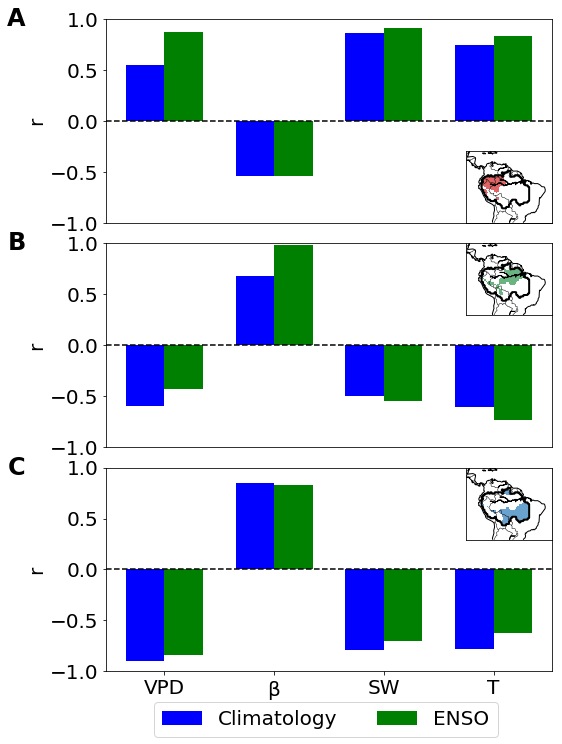

In [12]:
# Figure 5

cor_r1 = pickle.load(open('/Users/killaars/PhD/Elnino/pickle/cor_r1.p', 'rb'))
cor_r2 = pickle.load(open('/Users/killaars/PhD/Elnino/pickle/cor_r2.p', 'rb'))
cor_r3 = pickle.load(open('/Users/killaars/PhD/Elnino/pickle/cor_r3.p', 'rb'))

# Values region 1
r1_VPD=cor_r1[0]
r1_SM=cor_r1[1]
r1_SW=cor_r1[2]
r1_TEMP=cor_r1[3]
r1_clim=(r1_VPD[0],r1_SM[0],r1_SW[0],r1_TEMP[0])
r1_enso=(r1_VPD[1],r1_SM[1],r1_SW[1],r1_TEMP[1])

# Values region 2
r2_VPD=cor_r2[0]
r2_SM=cor_r2[1]
r2_SW=cor_r2[2]
r2_TEMP=cor_r2[3]
r2_clim=(r2_VPD[0],r2_SM[0],r2_SW[0],r2_TEMP[0])
r2_enso=(r2_VPD[1],r2_SM[1],r2_SW[1],r2_TEMP[1])

# Values region 3
r3_VPD=cor_r3[0]
r3_SM=cor_r3[1]
r3_SW=cor_r3[2]
r3_TEMP=cor_r3[3]
r3_clim=(r3_VPD[0],r3_SM[0],r3_SW[0],r3_TEMP[0])
r3_enso=(r3_VPD[1],r3_SM[1],r3_SW[1],r3_TEMP[1])

# Number of variables
N = 4
# Name of variables
labels=['VPD',r'$ \beta $','SW','T']

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

# -- Create figure
fig = plt.figure(figsize=[8,12])
gs = GridSpec(3,1,height_ratios=[1,1,1])
gs.update(hspace=0.1)
ylim=(-1,1)

# Region 1
ax1 = fig.add_subplot(gs[0,0])
rects1 = ax1.bar(ind, r1_clim, width, color='b')
rects2 = ax1.bar(ind+width, r1_enso, width, color='g')
ax1.set_ylim(ylim)
ax1.set_ylabel('r')
ax1.text(-0.2,1.0,'A',transform=ax1.transAxes,va='center',ha='center',weight='bold',size='large')
ax1.xaxis.set_major_locator(plt.NullLocator())
plt.axhline(0,color='k',linestyle='--')

# -- Plot inset for rainforest location
plt.axes([0.75,0.611,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(rainforest_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Reds',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

# Region 2
ax2 = fig.add_subplot(gs[1,0])
rects1 = ax2.bar(ind, r2_clim, width, color='b')
rects2 = ax2.bar(ind+width, r2_enso, width, color='g')
ax2.set_ylim(ylim)
ax2.set_ylabel('r')

ax2.text(-0.2,1.0,'B',transform=ax2.transAxes,va='center',ha='center',weight='bold',size='large')
ax2.xaxis.set_major_locator(plt.NullLocator())
plt.axhline(0,color='k',linestyle='--')

# -- Plot inset for monsoon location
plt.axes([0.75,0.504,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(monsoon_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Greens',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

# Region 3

ax3 = fig.add_subplot(gs[2,0])
rects1 = ax3.bar(ind, r3_clim, width, color='b')
rects2 = ax3.bar(ind+width, r3_enso, width, color='g')
ax3.set_ylim(ylim)
ax3.set_ylabel('r')
plt.xticks(np.arange(4)+width/2,labels)
ax3.text(-0.2,1.0,'C',transform=ax3.transAxes,va='center',ha='center',weight='bold',size='large')
plt.axhline(0,color='k',linestyle='--')
ax3.legend((rects1[0], rects2[0]), ('Climatology', 'ENSO'), bbox_to_anchor=(0.9, -0.1),ncol=2)


# -- Plot inset for savanna location
plt.axes([0.75,0.244,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(savanna_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Blues',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

plt.savefig("/Users/killaars/PhD/Elnino/Figures_paper/Figure_5.pdf", bbox_inches='tight', dpi=300)
plt.show()

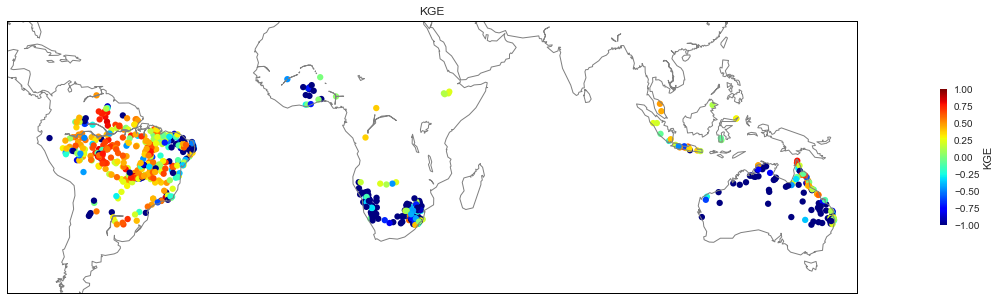

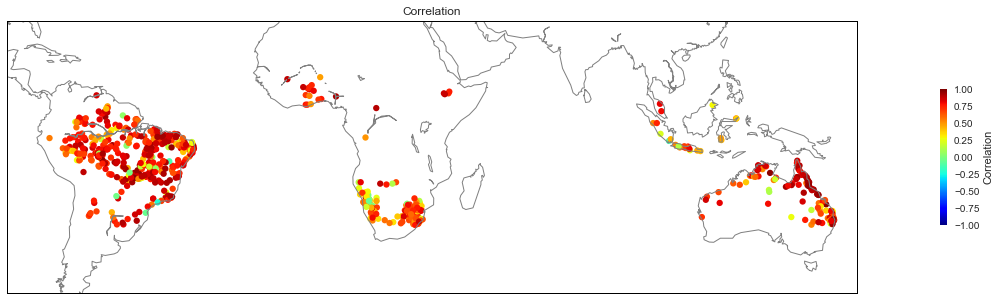

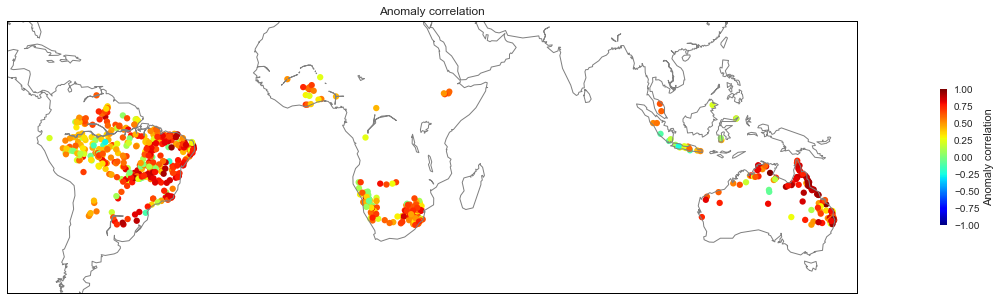

-0.0033059870126
0.749717338561
0.606218055207
(692,) (692,) (692,)
(342,) (628,) (576,)
49.421965317919074 90.7514450867052 83.23699421965318
(235,) (564,) (438,)
33.959537572254334 81.5028901734104 63.29479768786127
(86,) (260,) (128,)
12.427745664739884 37.57225433526012 18.497109826589597


In [13]:
# MSWEP analysis

import numpy as np
import os,sys
import pandas as pd
import netCDF4 as nc
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import fileinput
%matplotlib inline

data = pd.read_csv('/Users/killaars/PhD/Elnino/Discharge/summary_MSWEP_all_hybam.txt',sep=";",index_col='id_from_grdc')

#print(sorted(data['num_of_month_pairs'].values))
data=data[data['num_of_month_pairs']>12]
#print(sorted(data['num_of_month_pairs'].values))

# Monthly Anomaly correlation
obs_ano=[]
sim_ano=[]
obs_rel_ano=[]
sim_rel_ano=[]
path='/Users/killaars/PhD/Elnino/Discharge/grdc/MSWEP_AMA_and_other/'
for file in os.listdir(path):
    if file.endswith('.txt'):
        #print(file)
        data_ano = pd.read_csv(os.path.join(path,file),sep=";",skiprows=3)
        f=open(os.path.join(path,file))
        text=f.readlines(0)
        for t in text:
            if t.endswith('.mon\n'):
                station=t.split("/")[-1]
                grdc_id=station[0:7]
        data_ano=data_ano.dropna()
        data_ano['date'] = pd.to_datetime(data_ano['date'])
        data_ano=data_ano.set_index('date')
        month_mean=data_ano.groupby([data_ano.index.month]).mean()
        #print(month_mean)
        for index in data_ano.index.values:
            #print(index)
            month=pd.to_datetime(index).month
            data_ano.loc[index,'observation_anomaly']=data_ano.loc[index,'observation']-month_mean.loc[int(month),'observation']
            data_ano.loc[index,'simulated_anomaly']=data_ano.loc[index,'simulation']-month_mean.loc[int(month),'simulation']
            data_ano['obs_relative_anomaly']=data_ano['observation_anomaly']/data_ano['observation'].mean()
            data_ano['sim_relative_anomaly']=data_ano['simulated_anomaly']/data_ano['simulation'].mean()
        #print(data_ano)
        obs_ano=np.append(obs_ano,data_ano['observation_anomaly'].values)        
        sim_ano=np.append(sim_ano,data_ano['simulated_anomaly'].values)
        obs_rel_ano=np.append(obs_rel_ano,data_ano['obs_relative_anomaly'].values)        
        sim_rel_ano=np.append(sim_rel_ano,data_ano['sim_relative_anomaly'].values)
        #print(obs_ano)
        #print(sim_ano)
        anomaly_correlation=data_ano.corr()
        #print(anomaly_correlation.iloc[2,3])
        data.loc[int(grdc_id),'anomaly_correlation']=anomaly_correlation.iloc[2,3]
        
# Same figure as above, only for SA

mask=data['model_longitude_in_arc_degree']<-35
data_SA = data[mask]
#data_SA = data
#print(sorted(data_SA['model_longitude_in_arc_degree'].values))

# plot KGE
# Plot locations on map
fig = plt.figure(figsize=(30,5))
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['kge_2012'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
# Make colorbar same size as figures
# divider = make_axes_locatable(sc)
# cax = divider.append_axes("right", size="5%", pad=0)
# cb=plt.colorbar(cax=cax,label='KGE')
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("KGE")
plt.title('KGE')

plt.savefig("/Users/killaars/PhD/Elnino/Figures_paper/KGE.pdf", bbox_inches='tight', dpi=300)
plt.show()

# plot Correlation
fig = plt.figure(figsize=(30,5))
# Plot locations on map
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['correlation'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("Correlation")
plt.title('Correlation')

plt.savefig("/Users/killaars/PhD/Elnino/Figures_paper/Correlation.pdf", bbox_inches='tight', dpi=300)
plt.show()

# plot anomaly correlation
fig = plt.figure(figsize=(30,5))
# Plot locations on map
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['anomaly_correlation'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("Anomaly correlation")
plt.title('Anomaly correlation')

plt.savefig("/Users/killaars/PhD/Elnino/Figures_paper/Anomaly_correlation.pdf", bbox_inches='tight', dpi=300)
plt.show()

KGE_val=sorted(data_SA["kge_2012"].values)
cor_val=sorted(data_SA["correlation"].values)
ano_val=sorted(data_SA["anomaly_correlation"].values)

# print(KGE_val)
# print(cor_val)
# print(ano_val)

# KGE_val = KGE_val[~np.isnan(KGE_val)]
# cor_val = cor_val[~np.isnan(cor_val)]
# ano_val = ano_val[~np.isnan(ano_val)]

print(np.nanmedian(KGE_val))
print(np.nanmedian(cor_val))
print(np.nanmedian(ano_val))

totalnumberofstations=6.92 #3.70 for amazon, 6.92 for whole world

print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_val=sorted(i for i in KGE_val if i >= 0)
cor_val=sorted(i for i in cor_val if i >= 0.3)
ano_val=sorted(i for i in ano_val if i >= 0.3)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
KGE_val=sorted(i for i in KGE_val if i >= 0.3)
cor_val=sorted(i for i in cor_val if i >= 0.5)
ano_val=sorted(i for i in ano_val if i >= 0.5)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
# KGE_val=sorted(i for i in KGE_val if i >= 0.4)
# cor_val=sorted(i for i in cor_val if i >= 0.6)
# ano_val=sorted(i for i in ano_val if i >= 0.6)
# print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
# KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
# print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
# KGE_val=sorted(i for i in KGE_val if i >= 0.5)
# cor_val=sorted(i for i in cor_val if i >= 0.7)
# ano_val=sorted(i for i in ano_val if i >= 0.7)
# print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
# KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
# print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
KGE_val=sorted(i for i in KGE_val if i >= 0.6)
cor_val=sorted(i for i in cor_val if i >= 0.8)
ano_val=sorted(i for i in ano_val if i >= 0.8)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)

In [ ]:
# ERA5 analysis

import numpy as np
import os,sys
import pandas as pd
import netCDF4 as nc
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import fileinput
%matplotlib inline

data = pd.read_csv('/Users/killaars/PhD/Elnino/Discharge/summary_ERA5_hybam_andGRDC.txt',sep=";",index_col='id_from_grdc')

#print(sorted(data['num_of_month_pairs'].values))
data=data[data['num_of_month_pairs']>12]
#print(sorted(data['num_of_month_pairs'].values))

# Monthly Anomaly correlation
obs_ano=[]
sim_ano=[]
obs_rel_ano=[]
sim_rel_ano=[]
path='/Users/killaars/PhD/Elnino/Discharge/grdc/ERA5/'
for file in os.listdir(path):
    if file.endswith('.txt'):
        #print(file)
        data_ano = pd.read_csv(os.path.join(path,file),sep=";",skiprows=3)
        f=open(os.path.join(path,file))
        text=f.readlines(0)
        for t in text:
            if t.endswith('.mon\n'):
                station=t.split("/")[-1]
                grdc_id=station[0:7]
        data_ano=data_ano.dropna()
        data_ano['date'] = pd.to_datetime(data_ano['date'])
        data_ano=data_ano.set_index('date')
        month_mean=data_ano.groupby([data_ano.index.month]).mean()
        #print(month_mean)
        for index in data_ano.index.values:
            #print(index)
            month=pd.to_datetime(index).month
            data_ano.loc[index,'observation_anomaly']=data_ano.loc[index,'observation']-month_mean.loc[int(month),'observation']
            data_ano.loc[index,'simulated_anomaly']=data_ano.loc[index,'simulation']-month_mean.loc[int(month),'simulation']
            data_ano['obs_relative_anomaly']=data_ano['observation_anomaly']/data_ano['observation'].mean()
            data_ano['sim_relative_anomaly']=data_ano['simulated_anomaly']/data_ano['simulation'].mean()
        #print(data_ano)
        obs_ano=np.append(obs_ano,data_ano['observation_anomaly'].values)        
        sim_ano=np.append(sim_ano,data_ano['simulated_anomaly'].values)
        obs_rel_ano=np.append(obs_rel_ano,data_ano['obs_relative_anomaly'].values)        
        sim_rel_ano=np.append(sim_rel_ano,data_ano['sim_relative_anomaly'].values)
        #print(obs_ano)
        #print(sim_ano)
        anomaly_correlation=data_ano.corr()
        #print(anomaly_correlation.iloc[2,3])
        data.loc[int(grdc_id),'anomaly_correlation']=anomaly_correlation.iloc[2,3]
        
# Same figure as above, only for SA

mask=data['model_longitude_in_arc_degree']<-35
data_SA = data[mask]
#print(sorted(data_SA['model_longitude_in_arc_degree'].values))

# plot KGE
# Plot locations on map
fig = plt.figure(figsize=(30,5))
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['kge_2012'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
# Make colorbar same size as figures
# divider = make_axes_locatable(sc)
# cax = divider.append_axes("right", size="5%", pad=0)
# cb=plt.colorbar(cax=cax,label='KGE')
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("KGE")
plt.title('KGE')
#plt.savefig('/Users/killaars/PhD/Elnino/Discharge/locations_stations.png',dpi=100)
plt.show()

# plot Correlation
fig = plt.figure(figsize=(30,5))
# Plot locations on map
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['correlation'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("Correlation")
plt.title('Correlation')
plt.show()

# plot anomaly correlation
fig = plt.figure(figsize=(30,5))
# Plot locations on map
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['anomaly_correlation'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("Anomaly correlation")
plt.title('Anomaly correlation')
#plt.savefig('/Users/killaars/PhD/Elnino/Discharge/locations_stations.png',dpi=100)
plt.show()

KGE_val=sorted(data_SA["kge_2012"].values)
cor_val=sorted(data_SA["correlation"].values)
ano_val=sorted(data_SA["anomaly_correlation"].values)

print(np.nanmedian(KGE_val))
print(np.nanmedian(cor_val))
print(np.nanmedian(ano_val))

totalnumberofstations=0.22 #3.65 for amazon, 6.87 for whole world

print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_val=sorted(i for i in KGE_val if i >= 0)
cor_val=sorted(i for i in cor_val if i >= 0.3)
ano_val=sorted(i for i in ano_val if i >= 0.3)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
KGE_val=sorted(i for i in KGE_val if i >= 0.3)
cor_val=sorted(i for i in cor_val if i >= 0.5)
ano_val=sorted(i for i in ano_val if i >= 0.5)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
# KGE_val=sorted(i for i in KGE_val if i >= 0.4)
# cor_val=sorted(i for i in cor_val if i >= 0.6)
# ano_val=sorted(i for i in ano_val if i >= 0.6)
# print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
# KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
# print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
# KGE_val=sorted(i for i in KGE_val if i >= 0.5)
# cor_val=sorted(i for i in cor_val if i >= 0.7)
# ano_val=sorted(i for i in ano_val if i >= 0.7)
# print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
# KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
# print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
KGE_val=sorted(i for i in KGE_val if i >= 0.6)
cor_val=sorted(i for i in cor_val if i >= 0.8)
ano_val=sorted(i for i in ano_val if i >= 0.8)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
#WHOLE WORLD

In [ ]:
# TRMM analysis

import numpy as np
import os,sys
import pandas as pd
import netCDF4 as nc
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import fileinput
%matplotlib inline

data = pd.read_csv('/Users/killaars/PhD/Elnino/Discharge/summary_TRMM_hybam_andGRDC.txt',sep=";",index_col='id_from_grdc')

#print(sorted(data['num_of_month_pairs'].values))
data=data[data['num_of_month_pairs']>12]
#print(sorted(data['num_of_month_pairs'].values))

# Monthly Anomaly correlation
obs_ano=[]
sim_ano=[]
obs_rel_ano=[]
sim_rel_ano=[]
path='/Users/killaars/PhD/Elnino/Discharge/grdc/TRMM/'
for file in os.listdir(path):
    if file.endswith('.txt'):
        #print(file)
        data_ano = pd.read_csv(os.path.join(path,file),sep=";",skiprows=3)
        f=open(os.path.join(path,file))
        text=f.readlines(0)
        for t in text:
            if t.endswith('.mon\n'):
                station=t.split("/")[-1]
                grdc_id=station[0:7]
        data_ano=data_ano.dropna()
        data_ano['date'] = pd.to_datetime(data_ano['date'])
        data_ano=data_ano.set_index('date')
        month_mean=data_ano.groupby([data_ano.index.month]).mean()
        #print(month_mean)
        for index in data_ano.index.values:
            #print(index)
            month=pd.to_datetime(index).month
            data_ano.loc[index,'observation_anomaly']=data_ano.loc[index,'observation']-month_mean.loc[int(month),'observation']
            data_ano.loc[index,'simulated_anomaly']=data_ano.loc[index,'simulation']-month_mean.loc[int(month),'simulation']
            data_ano['obs_relative_anomaly']=data_ano['observation_anomaly']/data_ano['observation'].mean()
            data_ano['sim_relative_anomaly']=data_ano['simulated_anomaly']/data_ano['simulation'].mean()
        #print(data_ano)
        obs_ano=np.append(obs_ano,data_ano['observation_anomaly'].values)        
        sim_ano=np.append(sim_ano,data_ano['simulated_anomaly'].values)
        obs_rel_ano=np.append(obs_rel_ano,data_ano['obs_relative_anomaly'].values)        
        sim_rel_ano=np.append(sim_rel_ano,data_ano['sim_relative_anomaly'].values)
        #print(obs_ano)
        #print(sim_ano)
        anomaly_correlation=data_ano.corr()
        #print(anomaly_correlation.iloc[2,3])
        data.loc[int(grdc_id),'anomaly_correlation']=anomaly_correlation.iloc[2,3]
        
# Same figure as above, only for SA

mask=data['model_longitude_in_arc_degree']<-35
data_SA = data[mask]
#print(sorted(data_SA['model_longitude_in_arc_degree'].values))

# plot KGE
# Plot locations on map
fig = plt.figure(figsize=(30,5))
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['kge_2012'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
# Make colorbar same size as figures
# divider = make_axes_locatable(sc)
# cax = divider.append_axes("right", size="5%", pad=0)
# cb=plt.colorbar(cax=cax,label='KGE')
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("KGE")
plt.title('KGE')
#plt.savefig('/Users/killaars/PhD/Elnino/Discharge/locations_stations.png',dpi=100)
plt.show()

# plot Correlation
fig = plt.figure(figsize=(30,5))
# Plot locations on map
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['correlation'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("Correlation")
plt.title('Correlation')
plt.show()

# plot anomaly correlation
fig = plt.figure(figsize=(30,5))
# Plot locations on map
# Worldwide
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=30,\
            llcrnrlon=-90,urcrnrlon=160,resolution='c')
m.drawcoastlines(color='.5')
m.drawmapboundary(fill_color='white')

x,y = m(data_SA["model_longitude_in_arc_degree"].values, data_SA["model_latitude_in_arc_degree"].values)                            # This is the step that transforms the data_SA into the map's projection
#m.plot(x,y, 'bo', markersize=5)

# Color the transformed points!
sc = plt.scatter(x,y, c=data_SA['anomaly_correlation'].values, vmin=-1, vmax =1, cmap=plt.cm.get_cmap('jet'), s=40, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.set_label("Anomaly correlation")
plt.title('Anomaly correlation')
#plt.savefig('/Users/killaars/PhD/Elnino/Discharge/locations_stations.png',dpi=100)
plt.show()

KGE_val=sorted(data_SA["kge_2012"].values)
cor_val=sorted(data_SA["correlation"].values)
ano_val=sorted(data_SA["anomaly_correlation"].values)

print(np.nanmedian(KGE_val))
print(np.nanmedian(cor_val))
print(np.nanmedian(ano_val))

totalnumberofstations=2.21 #3.65 for amazon, 6.87 for whole world

print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_val=sorted(i for i in KGE_val if i >= 0)
cor_val=sorted(i for i in cor_val if i >= 0.3)
ano_val=sorted(i for i in ano_val if i >= 0.3)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
KGE_val=sorted(i for i in KGE_val if i >= 0.3)
cor_val=sorted(i for i in cor_val if i >= 0.5)
ano_val=sorted(i for i in ano_val if i >= 0.5)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
# KGE_val=sorted(i for i in KGE_val if i >= 0.4)
# cor_val=sorted(i for i in cor_val if i >= 0.6)
# ano_val=sorted(i for i in ano_val if i >= 0.6)
# print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
# KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
# print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
# KGE_val=sorted(i for i in KGE_val if i >= 0.5)
# cor_val=sorted(i for i in cor_val if i >= 0.7)
# ano_val=sorted(i for i in ano_val if i >= 0.7)
# print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
# KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
# print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
KGE_val=sorted(i for i in KGE_val if i >= 0.6)
cor_val=sorted(i for i in cor_val if i >= 0.8)
ano_val=sorted(i for i in ano_val if i >= 0.8)
print(np.shape(KGE_val),np.shape(cor_val),np.shape(ano_val))
KGE_perc,cor_perc,ano_perc=np.shape(KGE_val)[0],np.shape(cor_val)[0],np.shape(ano_val)[0]
print(KGE_perc/totalnumberofstations,cor_perc/totalnumberofstations,ano_perc/totalnumberofstations)
#WHOLE WORLD